In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (60000, 784)
Test data shape: (10000, 784)


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

encoder_inputs = keras.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     50,240 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        130 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        130 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,500 (197.27 KB)

 Trainable params: 50,500 (197.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,152 (199.81 KB)

 Trainable params: 51,152 (199.81 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Defines the forward pass for the VAE for inference."""
        _, _, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=-1
            )
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - kl_loss: 1.9181 - loss: 30.9503 - reconstruction_loss: 29.0322 - val_kl_loss: 2.0188 - val_loss: 30.2032 - val_reconstruction_loss: 28.1844
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 2.1398 - loss: 30.5270 - reconstruction_loss: 28.3872 - val_kl_loss: 2.2745 - val_loss: 29.9524 - val_reconstruction_loss: 27.6779
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.2667 - loss: 30.2735 - reconstruction_loss: 28.0069 - val_kl_loss: 2.2765 - val_loss: 29.8278 - val_reconstruction_loss: 27.5513
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.3472 - loss: 30.1431 - reconstruction_loss: 27.7960 - val_kl_loss: 2.3304 - val_loss: 29.7516 - val_reconstruction_loss: 27.4212
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.4020 - loss: 30.0373 - reconstruction_loss: 27.6352 - val_kl_loss: 2.3879 - val_loss: 29.6782 - val_reconstruction_loss: 27.2903
Epoch 6/10
469/469 ━━━━━━━━━

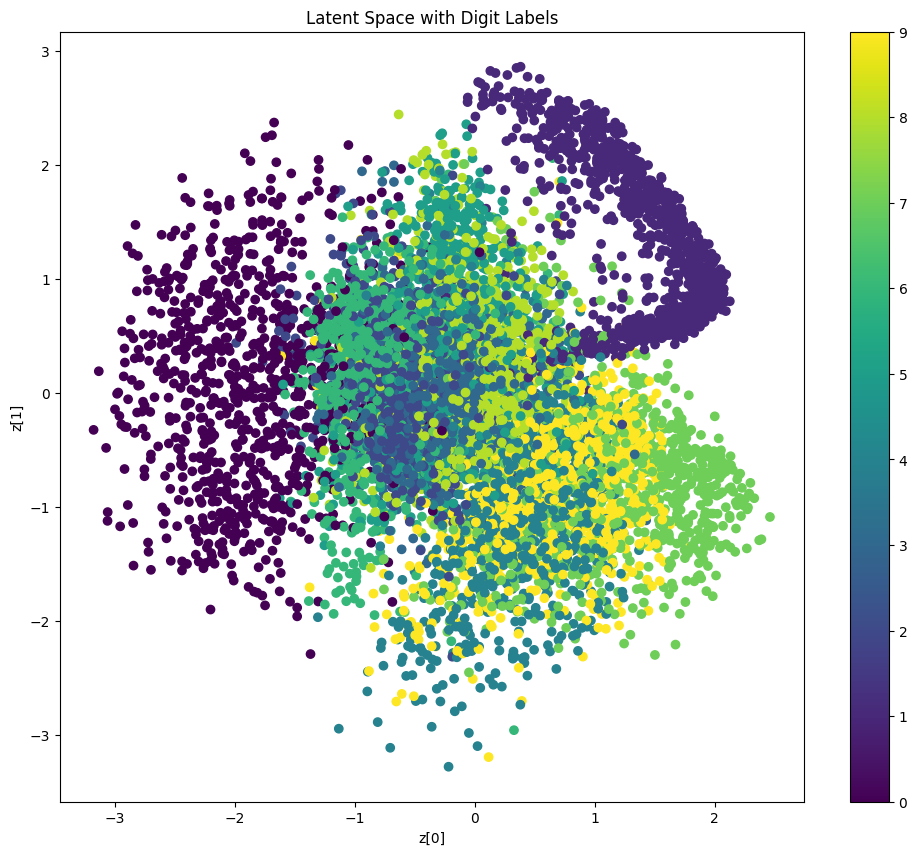

In [ ]:
def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space with Digit Labels")
    plt.show()

plot_label_clusters(vae, x_test, y_test)

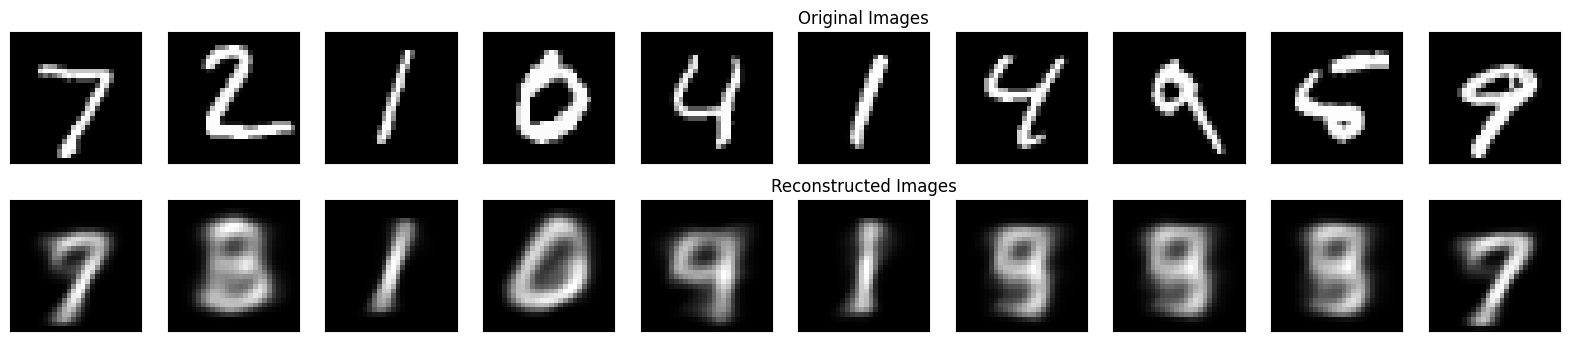

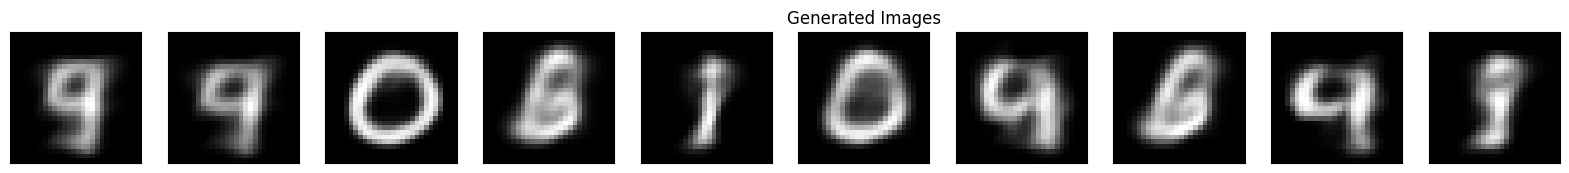

In [ ]:
n_images = 10
test_images = x_test[:n_images]
_, _, z = vae.encoder.predict(test_images, verbose=0)
reconstructed_images = vae.decoder.predict(z, verbose=0)

plt.figure(figsize=(20, 4))
for i in range(n_images):
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_images // 2:
        ax.set_title("Original Images")

    ax = plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_images // 2:
        ax.set_title("Reconstructed Images")
plt.show()

n_generated = 10
random_latent_vectors = tf.random.normal(shape=[n_generated, latent_dim])
generated_images = vae.decoder.predict(random_latent_vectors, verbose=0)

plt.figure(figsize=(20, 2))
for i in range(n_generated):
    ax = plt.subplot(1, n_generated, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_generated // 2:
        ax.set_title("Generated Images")
plt.show()